# Preparation

## Imports

In [1]:
# packages
import matplotlib.pyplot as plt
import numpy as np
import sys

import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# PyTorch
import torch.optim
from torch import nn
from torchvision import transforms
import torch
import torchvision.transforms.functional as tf

# Dataset to train and test
from torchvision.datasets import MNIST
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset

from IPython.display import clear_output

In [2]:
from IPython.core.ultratb import VerboseTB
VerboseTB._tb_highlight = "bg:#e68cc3"

if "dracula" in plt.style.available:
    plt.style.use("dracula")

## Devices

In [3]:
cpu_device = torch.device("cpu")

# Windows with NVidia GPU
if torch.cuda.is_available():
    gpu_device = torch.device("cuda")

# Mac with Apple Silicon
if torch.has_mps:
    gpu_device = torch.device("mps")

# Kaggle competition

## Network

In [53]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.epoch_counter = 0
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(1600, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        output = self.layers(input)
        return output

## Preparing Dataset

In [125]:
label_transforms = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x).to(torch.long)),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    transforms.Normalize((0.1307,), (0.3081,)),
])
img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    transforms.Normalize((0.1307,), (0.3081,)),
])
img_transforms_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    transforms.RandomRotation(degrees=(-5, 5)),
    transforms.RandomCrop(24),
    transforms.RandomChoice([
        transforms.Resize(28, antialias=True),
        transforms.Pad(2)
    ]),
    transforms.Normalize((0.1307,), (0.3081,)),
])
img_transforms_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    transforms.RandomRotation(degrees=(-5, 5)),
    transforms.Normalize((0.1307,), (0.3081,)),
])
img_transforms_3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    transforms.RandomCrop(24),
    transforms.RandomChoice([
        transforms.Resize(28, antialias=True),
        transforms.Pad(2)
    ]),
    transforms.Normalize((0.1307,), (0.3081,)),
])

In [126]:
class MnistDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None, train=False):
        df = pd.read_csv(annotations_file)
        self.img_pixels = df.loc[:, df.columns!="label"].apply(lambda x: x / 255).values.reshape(df.__len__(), 28, 28)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.img_labels = df["label"].astype("long").values if self.train else None

    def __len__(self):
        return len(self.img_pixels)

    def __getitem__(self, idx):
        image = self.img_pixels[idx]
        if self.transform:
            image = self.transform(image)
        if self.train:
            label = self.img_labels[idx]
            if self.target_transform:
                label = self.target_transform(label)
            return image, label
        else:
            return image

In [128]:
mnist_train_dataset = MnistDataset("train.csv", transform=img_transforms, target_transform=label_transforms, train=True)
mnist_train_dataset_1 = MnistDataset("train.csv", transform=img_transforms_1, target_transform=label_transforms, train=True)
mnist_train_dataset_2 = MnistDataset("train.csv", transform=img_transforms_2, target_transform=label_transforms, train=True)
mnist_train_dataset_3 = MnistDataset("train.csv", transform=img_transforms_3, target_transform=label_transforms, train=True)
mnist_test_dataset = MnistDataset("test.csv", transform=test_transforms, train=False)

mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=32, shuffle=False)
mnist_train_loader_1 = DataLoader(mnist_train_dataset_1, batch_size=32, shuffle=False)
mnist_train_loader_2 = DataLoader(mnist_train_dataset_2, batch_size=32, shuffle=False)
mnist_train_loader_3 = DataLoader(mnist_train_dataset_3, batch_size=32, shuffle=False)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=32, shuffle=False)

## Function for training

In [129]:
def train_kaggle(network: nn.Module, train_loader: DataLoader, loss = None, optim: torch.optim = None,
                 learning_rate: float = 0.01, epochs: int =10, gpu: bool = False,
                 plot: bool = False, verbose: bool = False):
    loss = loss or nn.NLLLoss()
    optimizer = optim or torch.optim.Adam(network.parameters(), lr=learning_rate)

    train_losses = []
    train_accuracies = []
    train_preds = []

    network.to(device=gpu_device) if gpu else network.to(device=cpu_device)
    network.train()
    for i in tqdm(range(epochs)):
        accuracies = []
        losses = []
        preds = []
        for X, y in train_loader:
            if gpu:
                X = X.to(device=gpu_device)
                y = y.to(device=gpu_device)
            optimizer.zero_grad()
            pred = network(X)
            batch_loss = loss(pred, y)
            losses.append(batch_loss.item())
            batch_loss.backward()
            optimizer.step()

            accuracies.append((np.argmax(pred.cpu().data.numpy(), axis=1) == y.cpu().data.numpy()).mean())
            preds.append(pred)
        train_losses.append(np.mean(losses))
        train_accuracies.append(np.mean(accuracies))
        train_preds.append(preds)
        if verbose:
            clear_output(True)
            sys.stdout.write(f"Epoch {i}: Train loss/accuracy: {train_losses[i]:.3f}/{train_accuracies[i]:.3f}")
        if plot:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.xlabel("Epoch")
            plt.ylabel("Losses")
            plt.plot(train_losses)
            plt.grid("on")
            plt.subplot(1, 2, 2)
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.plot(train_accuracies)
            plt.grid("on")
            plt.show()
    return train_accuracies, train_losses, train_preds

Epoch 19: Train loss/accuracy: 0.093/0.977

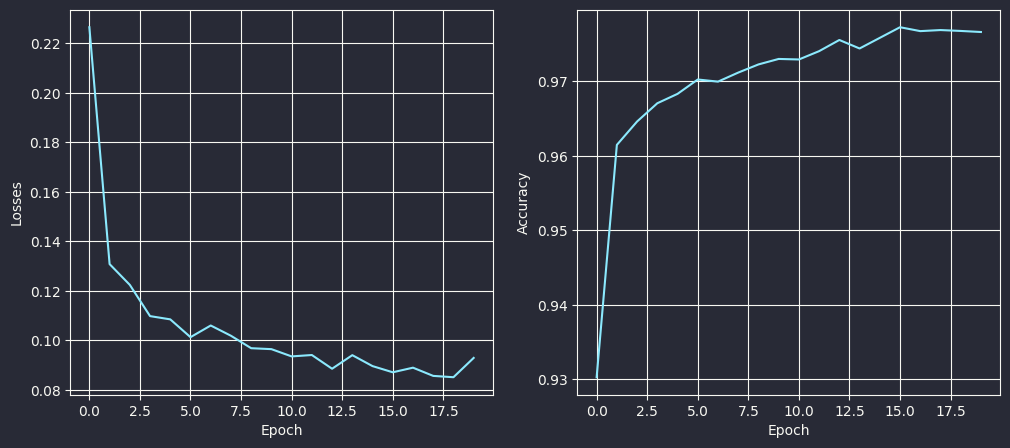

100%|██████████| 20/20 [02:46<00:00,  8.31s/it]


In [130]:
cnn = CNN()
tr_ac, tr_ls, preds = train_kaggle(cnn, mnist_train_loader, epochs=20, loss=nn.CrossEntropyLoss(), gpu=True, verbose=True, plot=True)

Epoch 19: Train loss/accuracy: 0.236/0.928

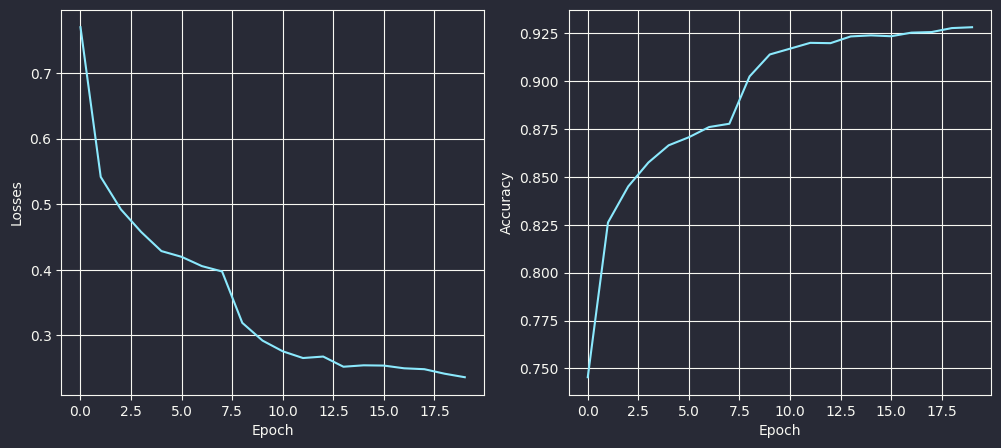

100%|██████████| 20/20 [04:07<00:00, 12.35s/it]


In [131]:
cnn_1 = CNN()
tr_ac, tr_ls, preds = train_kaggle(cnn_1, mnist_train_loader_1, epochs=20, loss=nn.CrossEntropyLoss(), gpu=True, verbose=True, plot=True)

Epoch 19: Train loss/accuracy: 2.303/0.107

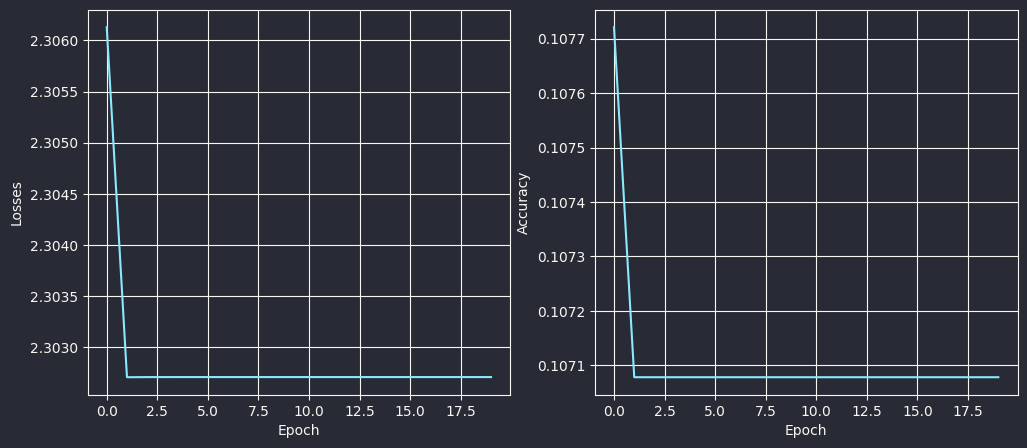

100%|██████████| 20/20 [03:43<00:00, 11.17s/it]


In [132]:
cnn_2 = CNN()
tr_ac, tr_ls, preds = train_kaggle(cnn_2, mnist_train_loader_2, epochs=20, loss=nn.CrossEntropyLoss(), gpu=True, verbose=True, plot=True)

Epoch 19: Train loss/accuracy: 2.303/0.107

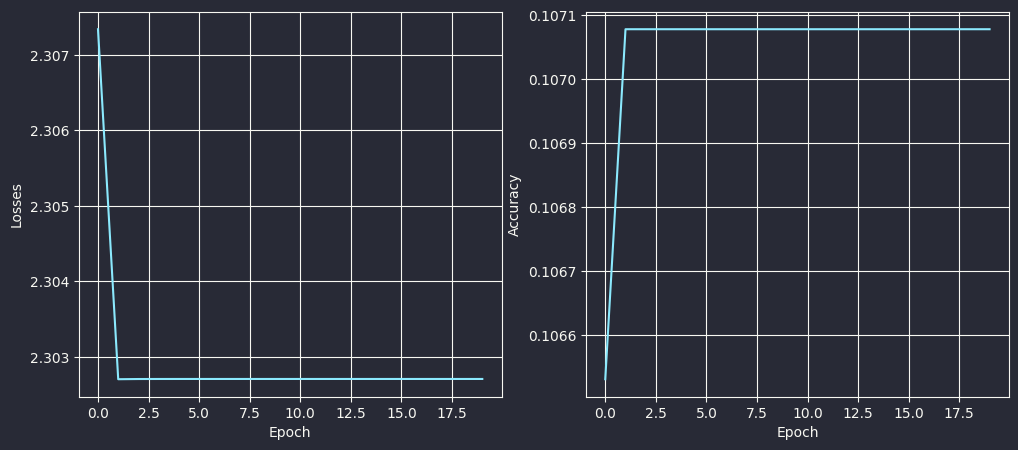

100%|██████████| 20/20 [02:57<00:00,  8.86s/it]


In [134]:
cnn_3 = CNN()
tr_ac, tr_ls, preds = train_kaggle(cnn_3, mnist_train_loader_3, epochs=20, loss=nn.CrossEntropyLoss(), gpu=True, verbose=True, plot=True)

## Test prediction

In [122]:
def test_kaggle(network: nn.Module, test_loader: DataLoader, gpu: bool = False):
    network.to(device=gpu_device) if gpu else network.to(device=cpu_device)
    network.eval()
    predictions = []
    with torch.no_grad():
        for X in tqdm(test_loader):
            if gpu:
                X = X.to(device=gpu_device)
            preds = network(X)
            predictions.append(preds)

    return predictions

In [123]:
preds = test_kaggle(cnn, mnist_test_loader, gpu=True)

100%|██████████| 875/875 [00:01<00:00, 757.07it/s]


In [124]:
submission = []
i = 1
for pred_batch in tqdm(preds):
    for probs in pred_batch:
        submission.append([i, probs.argmax().item()])
        i += 1
result = pd.DataFrame(submission, columns=["ImageID", "Label"])
result.to_csv("submission.csv", index=False)

100%|██████████| 875/875 [00:05<00:00, 155.35it/s]
